In [1]:
# Standard Python modules
import os, sys
import glob
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colorbar import Colorbar # different way to handle colorbar
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import metpy
from metpy.interpolate import cross_section
import textwrap

# Extra 
from scipy.integrate import trapz
from scipy.ndimage import gaussian_filter    # smoothing contour lines
from IPython.display import Image, display
import wrf
import netCDF4 as nc

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, make_cmap, plot_maxmin_points
import nclcmaps as nclc
from utils import find_perpindicular_line, find_parallel_line, find_intersection_two_lines, add_days_to_date
from wrf_funcs_preprocess import calculate_WRF_vertical_cross

In [2]:
# Set up paths
server= 'great'
if server == 'great':
    path_to_data = '/home/nash/DATA/data/'
else:
    path_to_data = '/work2/08540/dlnash/frontera/data/'                                      # project data -- read only

path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures


## Import AR Data

In [3]:
# Select lat/lon grid
lonmin = 60
lonmax = 115
latmin = 15
latmax = 60

## inner domain extent
## latmin, latmax, lonmin, lonmax
d02_ext = [22.05, 40.33, 68.24, 99.12]


In [4]:
## Get lines and points for mesoscale analysis

# hlat, hlon, tlat, tlon
Line1 = [39.5, 71., 32.25, 81.]
x1, y1, x2, y2 = Line1[3],Line1[2],Line1[1],Line1[0]

# calculate parallel lines
Line2, eq1, eq2 = find_parallel_line(x1, y1, x2, y2, -3., 69.,  80.)
Line3, eq1, eq3 = find_parallel_line(x1, y1, x2, y2, -2., 69.,  80.)

## calculate perpindicular cross section lines
newx_lst = [74.5, 76., 76.25, 78.5]
newx_lst = [74.25, 76.25]
newline = []
ptlst = []
for i, newx in enumerate(newx_lst):
    # get perpindicular line
    line, eq = find_perpindicular_line(x1, y1, x2, y2, newx)
    newline.append(line)
    # get intersecting point for each newline and Line3
    pt = find_intersection_two_lines(eq2[0], eq2[1], eq[0], eq[1])
    ptlst.append(pt)
    
print(newline) # meridional lines
line_lst = [Line2, Line3]
print(line_lst) # zonal lines

[[29.212715517241378, 68.5, 37.14375, 74.25], [25.0040948275862, 68.5, 35.693749999999994, 76.25]]
[[37.949999999999996, 69.0, 29.974999999999994, 80.0], [38.949999999999996, 69.0, 30.974999999999994, 80.0]]


## Load Data

In [5]:
arname = ['jan2002', 'feb2010']
ar_lst = []
terline_lst = []
dslst_2D = []
arcase_cross = []
for j, ar in enumerate(arname):
    # import configuration file for case study choice
    yaml_doc = '../data/ar_casestudy.yml'
    config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
    ar_dict = config[ar]

    year = ar_dict['year']
    month = ar_dict['month']
    start_date = ar_dict['start_date']
    end_date = add_days_to_date(ar_dict['end_date'], 1)
    print(start_date, end_date)
    ar_ID = ar_dict['ar_ID']
    print(ar_ID)
    
    date_lst = pd.date_range(start_date, end_date, freq='1D')
    
    if server == 'great':
        wrf_filenames = ar_dict['wrf_files'] # this only works on great
    else:
        wrf_filenames = [path_to_data + 'wrf_norris/20211113_case/wrfout_d01_2010-02-04_03:00:00'] # this only works on Frontera
        
    ## open terrain data and get cross section coordinates
    wrfin = nc.Dataset(wrf_filenames[0])
    ter = wrf.getvar(wrfin, 'ter', timeidx=-1) # get terrain height
    terline = []
    for i, line in enumerate(line_lst):
        # Set the start point and end point for the cross section
        start_point = wrf.CoordPair(lat=line[0], lon=line[1])
        end_point = wrf.CoordPair(lat=line[2], lon=line[3])
        print(start_point, end_point)
        terline.append(wrf.interpline(ter, wrfin=wrfin, start_point=start_point, end_point=end_point, latlon=True))
    terline_lst.append(terline)
    
    ## Get 2D WRF data
    domains = ['d01', 'd02', 'd01', 'd02', 'd02']
    varname_lst = ['ivt', 'prec', 'zerodegisotherm', 'prec', 'prec']
    res_lst = ['3hr', '3hr', '3hr', '3hr', '3hr']

    ## loop through each ds
    ds_lst = []
    for i, (dom, varname, res) in enumerate(zip(domains, varname_lst, res_lst)):
        if server == 'great':
            data_path = path_to_data + 'wrf_hasia/'
        else:
            data_path = path_to_data + 'wrf_preprocessed_data/wrf_6km/'

        if res == 'daily':
            filename_pattern = '{0}/{1}/daily/out.wrf6km.{1}.daily_{2}.nc'.format(dom, varname, year)
        else: 
            filename_pattern = '{0}/{1}/3hr/tmp_{2}.nc'.format(dom, varname, year)

        fname = data_path + filename_pattern
        print(fname)
        ds = xr.open_dataset(fname)

        # subset to just ar days
        ds = ds.sel(time = slice(start_date, end_date))

        if varname == 'ivt':
            ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivtu**2 + ds.ivtv**2))
        if varname == 'geopotential':
            ds = ds.sel(lev=250.)
        if varname == 'prec':
            # calculate rain
            ds['rain'] = ds.prec - ds.snow
            # Calculate precipitation rate
            ds = ds.shift(time=-1) - ds # if in xarray
            ds = ds/3. # convert to mm per hour

        ds_lst.append(ds)
    # dslst_2D.append(ds_lst) ## do we need this??
    
    ## now perform cross interpolation using terrain cross section coords
    # interpolate precipitation and snow across cross section line
    varlst = ['ivt', 'rain', 'z', 'snow', 'prec']

    final_cross = []
    for i, (var, data) in enumerate(zip(varlst, ds_lst)):
        v = data[var]
        cross = []
        for j, ter in enumerate(terline):
            # get the along AR axis coord_pairs for that timestep
            coord_pairs = ter.coords["xy_loc"].values
            yvals = [pair.lat for pair in coord_pairs]
            xvals = [pair.lon for pair in coord_pairs]
            x = xr.DataArray(xvals, dims="z")
            y = xr.DataArray(yvals, dims="z")
            cross.append(v.interp(lon=x, lat=y))

        final_cross.append(cross)
    arcase_cross.append(final_cross)
    

2002-01-10 2002-01-14
[71513]
CoordPair(lat=37.949999999999996, lon=69.0) CoordPair(lat=29.974999999999994, lon=80.0)
CoordPair(lat=38.949999999999996, lon=69.0) CoordPair(lat=30.974999999999994, lon=80.0)
/home/nash/DATA/data/wrf_hasia/d01/ivt/3hr/tmp_2002.nc
/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_2002.nc
/home/nash/DATA/data/wrf_hasia/d01/zerodegisotherm/3hr/tmp_2002.nc
/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_2002.nc
/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_2002.nc
2010-02-04 2010-02-09
[97756]
CoordPair(lat=37.949999999999996, lon=69.0) CoordPair(lat=29.974999999999994, lon=80.0)
CoordPair(lat=38.949999999999996, lon=69.0) CoordPair(lat=30.974999999999994, lon=80.0)
/home/nash/DATA/data/wrf_hasia/d01/ivt/3hr/tmp_2010.nc
/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_2010.nc
/home/nash/DATA/data/wrf_hasia/d01/zerodegisotherm/3hr/tmp_2010.nc
/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_2010.nc
/home/nash/DATA/data/wrf_hasia/d02/prec/3hr/tmp_2010.nc


In [6]:
# cross sections for Jan 2002 case
ivt_crs = arcase_cross[0][0]
rain_crs = arcase_cross[0][1]
freeze_crs = arcase_cross[0][2]
snow_crs = arcase_cross[0][3]
prec_crs = arcase_cross[0][4]

# cross sections for Feb 2010 case
ivt_crs2 = arcase_cross[1][0]
rain_crs2 = arcase_cross[1][1]
freeze_crs2 = arcase_cross[1][2]
snow_crs2 = arcase_cross[1][3]
prec_crs2 = arcase_cross[1][4]

## Plot Hovmoller Diagrams

For a helpful tutorial on building a plotting grid using GridSpec - visit [this blog post](http://www.sc.eso.org/~bdias/pycoffee/codes/20160407/gridspec_demo.html).

In [9]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

row_lbl = ['Foothill Zone', 'Montane Zone']

degree_sign= u'30\N{DEGREE SIGN}N'
print(degree_sign)

### Get y-tick and y-labels for both cases
y1 = ivt_crs[0].time.values
y2 = ivt_crs2[0].time.values

y_lst = [y1, y2]
ylbl_lst = []
ytick_lst = []
for i, y in enumerate(y_lst):
    y_lbl = []
    ytick_lst.append(y)
    for j in range(len(y)):
        t = pd.to_datetime(str(y[j]))
        y_lbl.append(t.strftime('%m-%d %H'))
    ylbl_lst.append(y_lbl)

30°N


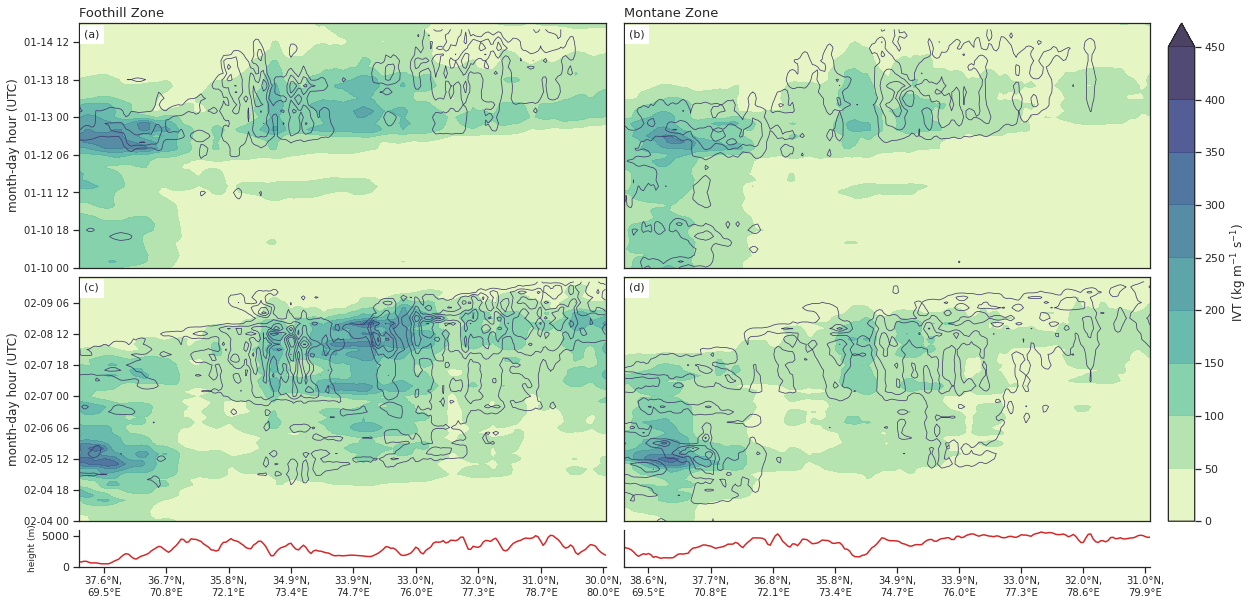

In [10]:
filepath = path_to_figs + 'IVT_hovmoller.png'
nrows = 3 # two row of hovmoller, one row of elevation
ncols = 3 # number of cross sections plus colorbar

# point location for (a) (b) (c) label annotation
xpt = 0.01
ypt = 0.975

# Create figure
fig = plt.figure(figsize=(20, 10))

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 0.15], width_ratios = [1, 1, 0.05], wspace=0.05, hspace=0.05)
## use gs[rows index, columns index] to access grids

## Plot Jan 2002 case
ttl = ['(a)', '(b)']
for k, (data, ter) in enumerate(zip(ivt_crs, terline_lst[0])):
    ax = fig.add_subplot(gs[0, k]) 

    # Contour Filled
    # xs = data.lon.values
    xs = ter.line_idx.values
    ys = data.time.values
    cflevs = np.arange(0, 500, 50)
    clipcmap = cmocean.tools.crop_by_percent(cmo.deep, 10, which='max', N=None)
    cf = ax.contourf(xs, ys, data.values, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max')
    
    # Contour Line
    data = prec_crs[k]
    # print(data.min(), data.max())
    clevs=np.arange(1, 11, 2)
    cl = ax.contour(xs, ys, data.values, clevs, colors='#3f396c', linewidths=0.75,
                    linestyles='solid')
    kw_clabels = {'fontsize': 6.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%.1f',
                  'rightside_up': True, 'use_clabeltext': True}
    # plt.clabel(cl, **kw_clabels)  

    # subtitles
    ax.set_title(row_lbl[k], loc='left',fontsize=13)
    
    # add text title
    ax.text(xpt, ypt, ttl[k], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
    # some plot parameters to make it look nice
    ax.set_xlim(xs.min(), xs.max())
    ax.get_xaxis().set_ticks([])
    
    if k == 0:
        ax.set_ylabel('month-day hour (UTC)')
        ## y-axis format dates/ticks
        y_ticks = ytick_lst[0]
        y_labels = ylbl_lst[0]
        ax.set_yticks(y_ticks[::6]) # set the labels every 12 hours
        ax.set_yticklabels(y_labels[::6], fontsize=10)
        ax.set_ylim(ys.min(), ys.max())
    if k > 0:
        ax.get_yaxis().set_ticks([])
    
# Plot Feb 2010 case
ttl = ['(c)', '(d)']
for k, (data, ter) in enumerate(zip(ivt_crs2, terline_lst[1])):
    ax = fig.add_subplot(gs[1, k]) 

    # Contour Filled
    # xs = data.lon.values
    xs = ter.line_idx.values
    ys = data.time.values
    cflevs = np.arange(0, 500, 50)
    clipcmap = cmocean.tools.crop_by_percent(cmo.deep, 10, which='max', N=None)
    cf = ax.contourf(xs, ys, data.values, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max')
    
    # Contour Line
    data = prec_crs2[k]
    # print(data.min(), data.max())
    clevs=np.arange(1, 11, 2)
    cl = ax.contour(xs, ys, data.values, clevs, colors='#3f396c', linewidths=0.75,
                    linestyles='solid')
    kw_clabels = {'fontsize': 6.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%.1f',
                  'rightside_up': True, 'use_clabeltext': True}
    # plt.clabel(cl, **kw_clabels)  
    
    # add terline to new axis
    ax2 = fig.add_subplot(gs[2, k])
    ax2.plot(xs, ter.values, color='tab:red')
    
    # some plot parameters to make it look nice
    ax.set_xlim(xs.min(), xs.max())
    ax.get_xaxis().set_ticks([])
    if k == 0:
        ax.set_ylabel('month-day hour (UTC)')
        ax2.set_ylabel('height (m)', fontsize=9)
        ## y-axis format dates/ticks
        y_ticks = ytick_lst[1]
        y_labels = ylbl_lst[1]
        ax.set_yticks(y_ticks[::6]) # set the labels every 12 hours
        ax.set_yticklabels(y_labels[::6], fontsize=10)
        ax.set_ylim(ys.min(), ys.max())
    if k > 0:
        ax.get_yaxis().set_ticks([])
        ax2.get_yaxis().set_ticks([])
        
    ax2.set_ylim(0, 6000)
    ax2.set_xlim(xs.min(), xs.max())
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Set the x-ticks to use latitude and longitude labels
    coord_pairs = ter.coords["xy_loc"].values
    x_ticks = np.arange(coord_pairs.shape[0])
    x_labels = [u"{:.1f}\N{DEGREE SIGN}N, {:.1f}\N{DEGREE SIGN}E".format(pair.lat, pair.lon) for pair in coord_pairs]
    # set the frequency of xtick labels
    ax2.set_xticks(x_ticks[10::25])
    ax2.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[10::25]], fontsize=10)
    
    # add text title
    ax.text(xpt, ypt, ttl[k], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
# Add color bar
cbax = plt.subplot(gs[0:2,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)')

    
## Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


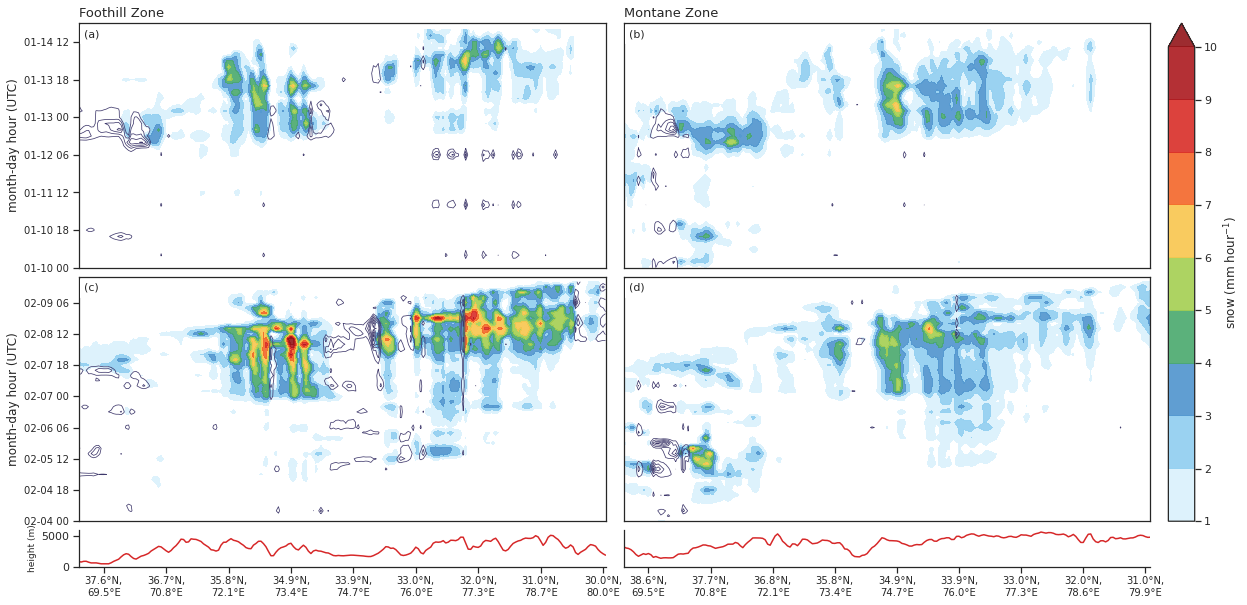

In [11]:
filepath = path_to_figs + 'prec_hovmoller.png'
nrows = 3 # two row of hovmoller, one row of elevation
ncols = 3 # number of cross sections plus colorbar

# point location for (a) (b) (c) label annotation
xpt = 0.01
ypt = 0.975

# Create figure
fig = plt.figure(figsize=(20, 10))

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 0.15], width_ratios = [1, 1, 0.05], wspace=0.05, hspace=0.05)
## use gs[rows index, columns index] to access grids

## Plot Jan 2002 case
ttl = ['(a)', '(b)']
for k, (data, ter) in enumerate(zip(snow_crs, terline_lst[0])):
    ax = fig.add_subplot(gs[0, k]) 

    # Contour Filled
    xs = ter.line_idx.values
    ys = data.time.values
    cflevs = np.arange(1, 11, 1)
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    cf = ax.contourf(xs, ys, data.values, levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    
    # Contour Line
    data = rain_crs[k]
    clevs=np.arange(1, 11, 2)
    cl = ax.contour(xs, ys, data.values, cflevs, colors='#3f396c', linewidths=0.75,
                    linestyles='solid')
    kw_clabels = {'fontsize': 6.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%.1f',
                  'rightside_up': True, 'use_clabeltext': True}
    # plt.clabel(cl, **kw_clabels) 

    # subtitles
    ax.set_title(row_lbl[k], loc='left',fontsize=13)
    
    # add text title
    ax.text(xpt, ypt, ttl[k], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
    # some plot parameters to make it look nice
    ax.set_xlim(xs.min(), xs.max())
    ax.get_xaxis().set_ticks([])
    
    if k == 0:
        ax.set_ylabel('month-day hour (UTC)')
        ## y-axis format dates/ticks
        y_ticks = ytick_lst[0]
        y_labels = ylbl_lst[0]
        ax.set_yticks(y_ticks[::6]) # set the labels every 12 hours
        ax.set_yticklabels(y_labels[::6], fontsize=10)
        ax.set_ylim(ys.min(), ys.max())
    if k > 0:
        ax.get_yaxis().set_ticks([])
    
# Plot Feb 2010 case
ttl = ['(c)', '(d)']
for k, (data, ter) in enumerate(zip(snow_crs2, terline_lst[1])):
    ax = fig.add_subplot(gs[1, k]) 

    # Contour Filled
    # xs = data.lon.values
    xs = ter.line_idx.values
    ys = data.time.values
    cflevs = np.arange(1, 11, 1)
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    cf = ax.contourf(xs, ys, data.values, levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    
    # Contour Line
    data = rain_crs2[k]
    clevs=np.arange(1, 11, 2)
    cl = ax.contour(xs, ys, data.values, cflevs, colors='#3f396c', linewidths=0.75,
                    linestyles='solid')
    kw_clabels = {'fontsize': 6.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%.1f',
                  'rightside_up': True, 'use_clabeltext': True}
    # plt.clabel(cl, **kw_clabels)
    
    # add terline to new axis
    ax2 = fig.add_subplot(gs[2, k])
    ax2.plot(xs, ter.values, color='tab:red')
    
    # some plot parameters to make it look nice
    ax.set_xlim(xs.min(), xs.max())
    ax.get_xaxis().set_ticks([])
    if k == 0:
        ax.set_ylabel('month-day hour (UTC)')
        ax2.set_ylabel('height (m)', fontsize=9)
        ## y-axis format dates/ticks
        y_ticks = ytick_lst[1]
        y_labels = ylbl_lst[1]
        ax.set_yticks(y_ticks[::6]) # set the labels every 12 hours
        ax.set_yticklabels(y_labels[::6], fontsize=10)
        ax.set_ylim(ys.min(), ys.max())
    if k > 0:
        ax.get_yaxis().set_ticks([])
        ax2.get_yaxis().set_ticks([])
        
    ax2.set_ylim(0, 6000)
    ax2.set_xlim(xs.min(), xs.max())
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Set the x-ticks to use latitude and longitude labels
    coord_pairs = ter.coords["xy_loc"].values
    x_ticks = np.arange(coord_pairs.shape[0])
    x_labels = [u"{:.1f}\N{DEGREE SIGN}N, {:.1f}\N{DEGREE SIGN}E".format(pair.lat, pair.lon) for pair in coord_pairs]
    # set the frequency of xtick labels
    ax2.set_xticks(x_ticks[10::25])
    ax2.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[10::25]], fontsize=10)
    
    # add text title
    ax.text(xpt, ypt, ttl[k], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
# Add color bar
cbax = plt.subplot(gs[0:2,-1]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('snow (mm hour$^{-1}$)')

    
## Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
